# E4CV:fourc 4-circle example

Compare with data acquired using SPEC

In _hkl_ *E4CV* geometry (https://people.debian.org/~picca/hkl/hkl.html#org7ef08ba):

<img src="3S+1D.png" alt="E4CV geometry" width="30%"/>

* xrays incident on the $\vec{x}$ direction (1, 0, 0)

axis  | moves    | rotation about axis
---   | :---     | :---
omega | sample   | $-\vec{y}$ `[0 -1 0]`
chi   | sample   | $\vec{x}$ `[1 0 0]`
phi   | sample   | $-\vec{y}$ `[0 -1 0]`
tth   | detector | $-\vec{y}$ `[0 -1 0]`

In SPEC *fourc* geometry (https://certif.com/spec_help/fourc.html):

name    | mnemonic   | description
-----   | -----      | -----
2theta  | tth        | Detector arm rotation
Omega   | om         | Rotates sample circles
Chi     | chi        | Sample tilt
Phi     | phi        | Sample rotation

No need for a mapping to rename the diffractometer axes between *SPEC* & *hlpy*.  Same names and meanings but default order is different.  Expect the UB orientation matix to be in different order, as well.

In [1]:
# mapping of axis names between hklpy and SPEC
AXIS_NAME_MAP = dict(
    # E4CV  fourc
    tth='tth',   # Detector arm rotation
    omega='th',  # Rotates chi around horizontal axis
    chi='chi',   # Rotates phi around beam axis
    phi='phi',   # Sample rotation around horizontal axis (when phi is co-linear with omega)
)

## Read the SPEC scan from the data file

The SPEC file provides all the information needed here.  The
[*spec2nexus*](https://github.com/prjemian/spec2nexus) 
(python) package can read the file and parse the content into useful 
structures, including deducing the diffractometer geometry in many cases.

In [2]:
import pyRestTable
from spec2nexus.spec import SpecDataFile

specfile = SpecDataFile("hkl_data/LNO_LAO_s14.dat")
specscan = specfile.getScan(14)

spec_d = specscan.diffractometer
spec_d.UB = spec_d.geometry_parameters["ub_matrix"][2]

terms = {
    "SPEC file": specfile.specFile,
    "scan #": specscan.scanNum,
    "SPEC scanCmd": specscan.scanCmd,
    "geometry": spec_d.geometry_name,
    "mode": spec_d.mode,
    "lattice": spec_d.lattice,
    "wavelength": spec_d.wavelength,
    "reflection 1": spec_d.reflections[0],
    "reflection 2": spec_d.reflections[1],
    "[UB]": spec_d.UB,
}
tbl = pyRestTable.Table()
tbl.labels = "term value".split()
for k, v in terms.items():
    tbl.addRow((k, v))
print(tbl)

============ =======================================================================================================================================================
term         value                                                                                                                                                  
============ =======================================================================================================================================================
SPEC file    LNO_LAO                                                                                                                                                
scan #       14                                                                                                                                                     
SPEC scanCmd hklscan  1.00133 1.00133  1.00133 1.00133  2.85 3.05  200 -400000                                                                                      
geometry  

## Plot the (_hkl_) trajectories in the scan

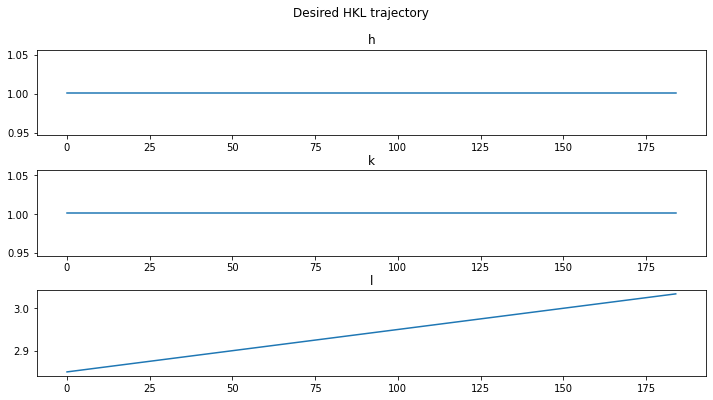

In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# plot the h, k, & l vs. point number
fig, axes = plt.subplots(3, 1, figsize=(12, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.2)

plt.suptitle('Desired HKL trajectory')
axes[0].plot(specscan.data["H"])
axes[0].set_title("h")
axes[1].plot(specscan.data["K"])
axes[1].set_title("k")
axes[2].plot(specscan.data["L"])
axes[2].set_title("l")
plt.show()

## Setup the *E4CV* diffractometer in *hklpy*

In [4]:
import gi
gi.require_version('Hkl', '5.0')
from hkl.diffract import E4CV
from hkl.util import Lattice

from ophyd import (PseudoSingle, SoftPositioner)
from ophyd import Component as Cpt

In [5]:
class Diffractometer(E4CV):
    h = Cpt(PseudoSingle, '')
    k = Cpt(PseudoSingle, '')
    l = Cpt(PseudoSingle, '')

    # use the SPEC axis names here
    omega = Cpt(SoftPositioner)
    chi = Cpt(SoftPositioner)
    phi = Cpt(SoftPositioner)
    tth = Cpt(SoftPositioner)

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        for p in self.real_positioners:
            p._set_position(0)  # give each a starting position

In [6]:
fourc = Diffractometer("", name="fourc")

In [7]:
# add the sample to the calculation engine
fourc.calc.new_sample(
    specfile.specFile,
    lattice=Lattice(
        a=spec_d.lattice.a, 
        b=spec_d.lattice.b, 
        c=spec_d.lattice.c,
        alpha=spec_d.lattice.alpha, 
        beta=spec_d.lattice.beta, 
        gamma=spec_d.lattice.gamma)
    )

HklSample(name='LNO_LAO', lattice=LatticeTuple(a=3.781726143, b=3.791444574, c=3.79890313, alpha=90.2546203, beta=90.01815424, gamma=89.89967858), ux=Parameter(name='None (internally: ux)', limits=(min=-180.0, max=180.0), value=0.0, fit=True, inverted=False, units='Degree'), uy=Parameter(name='None (internally: uy)', limits=(min=-180.0, max=180.0), value=0.0, fit=True, inverted=False, units='Degree'), uz=Parameter(name='None (internally: uz)', limits=(min=-180.0, max=180.0), value=0.0, fit=True, inverted=False, units='Degree'), U=array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]), UB=array([[ 1.66146225e+00, -2.89938471e-03,  5.11196668e-04],
       [ 0.00000000e+00,  1.65721725e+00,  7.34922202e-03],
       [ 0.00000000e+00,  0.00000000e+00,  1.65394723e+00]]), reflections=[])

## Use the UB orientation matrix from *SPEC*

In [8]:
# get the UB matrix from the SPEC data
# SPEC's UB first row moved (via numpy slicing) to last row for hklpy
fourc.UB.put(spec_d.UB[[1,2,0], :])
print(spec_d.UB)
print(fourc.UB.get())

# calculate angles with hklpy using the SPEC UB matrix
fourc.engine.mode = "bissector"
fourc.calc["phi"].limits = (-50, 100)
fourc.calc["tth"].limits = (-2, 180)
print("(002) :", fourc.forward((0, 0, 2)))
print("(113) :", fourc.forward((1, 1, 3)))

[[-1.65871244e+00  9.82002413e-02 -3.89705578e-04]
 [-9.55499031e-02 -1.65427863e+00  2.42844486e-03]
 [ 2.62981891e-04  9.81574682e-03  1.65396181e+00]]
[[-9.55499053e-02 -1.65427875e+00  2.42825603e-03]
 [ 2.63161907e-04  9.81566638e-03  1.65396189e+00]
 [-1.65871254e+00  9.82003048e-02 -3.89644168e-04]]
(002) : PosCalcE4CV(omega=23.915206114844626, chi=89.91480547663566, phi=99.11611601380724, tth=47.83041222968925)
(113) : PosCalcE4CV(omega=42.33129428600627, chi=115.20291094237979, phi=48.133061440101486, tth=84.66258857201254)


In [9]:
# Compare these angles with those from SPEC
tbl = pyRestTable.Table()
tbl.labels = "(hkl) motor E4CV SPEC".split()
for r in spec_d.reflections:
    sol = fourc.forward((r.h, r.k, r.l))
    nm = f"{r.h:.0f} {r.k:.0f} {r.l:.0f}"
    for em, sm in AXIS_NAME_MAP.items():
        row = [f"({nm})", em]
        row.append(f"{getattr(sol, em):.5f}")
        row.append(f"{r.angles[sm]:.5f}")
        tbl.addRow(row)
print(tbl)

======= ===== ========= =========
(hkl)   motor E4CV      SPEC     
======= ===== ========= =========
(0 0 2) tth   47.83041  38.09875 
(0 0 2) omega 23.91521  19.13350 
(0 0 2) chi   89.91481  90.01350 
(0 0 2) phi   99.11612  0.00000  
(1 1 3) tth   84.66259  65.64400 
(1 1 3) omega 42.33129  32.82125 
(1 1 3) chi   115.20291 115.23625
(1 1 3) phi   48.13306  48.13150 
======= ===== ========= =========



## Setup the UB orientation matrix using *hklpy*

In [10]:
fourc.calc.wavelength = 1.239424258 # Angstrom

refs = [
    fourc.calc.sample.add_reflection(
        r.h, r.k, r.l, 
        position=fourc.calc.Position(
            tth=r.angles["tth"],
            omega=r.angles["th"],
            chi=r.angles["chi"],
            phi=r.angles["phi"],
        )
    )
    for r in spec_d.reflections
]

fourc.calc.sample.compute_UB(*refs)

tbl = pyRestTable.Table()
tbl.labels = "term value".split()
tbl.addRow(("SPEC [UB]", spec_d.UB))
tbl.addRow(("E4CV [UB]", fourc.UB.get()))
print(tbl)

========= ===================================================
term      value                                              
========= ===================================================
SPEC [UB] [[-1.65871244e+00  9.82002413e-02 -3.89705578e-04] 
           [-9.55499031e-02 -1.65427863e+00  2.42844486e-03] 
           [ 2.62981891e-04  9.81574682e-03  1.65396181e+00]]
E4CV [UB] [[-9.55498634e-02 -1.65427875e+00  2.42844498e-03] 
           [ 2.63111155e-04  9.81585901e-03  1.65396189e+00] 
           [-1.65871254e+00  9.82002627e-02 -3.89705597e-04]]
========= ===================================================



In [11]:
tbl = pyRestTable.Table()
tbl.labels = "term value".split()
tbl.addRow(("energy, keV", fourc.calc.energy))
tbl.addRow(("wavelength, angstrom", fourc.calc.wavelength))
tbl.addRow(("position", fourc.position))
tbl.addRow(("sample name", fourc.sample_name.get()))
tbl.addRow(("[U]", fourc.U.get()))
tbl.addRow(("[UB]", fourc.UB.get()))
tbl.addRow(("lattice", fourc.lattice.get()))
print(tbl)

print(f"sample\t{fourc.calc.sample}")

==================== =========================================================================
term                 value                                                                    
==================== =========================================================================
energy, keV          10.00337045202483                                                        
wavelength, angstrom 1.239424258                                                              
position             DiffractometerPseudoPos(h=-0.0, k=0.0, l=0.0)                            
sample name          LNO_LAO                                                                  
[U]                  [[-5.75094968e-02 -9.98327391e-01  5.92267768e-03]                       
                      [ 1.58361191e-04  5.92337392e-03  9.99982444e-01]                       
                      [-9.98344947e-01  5.75094251e-02 -1.82553939e-04]]                      
[UB]                 [[-9.55498634e-02 -1.65427875

In [12]:
print(fourc.engine.modes)
print("(002) ?", fourc.inverse((19.1335, 90.0135, 0, 38.09875,)))
print("(113) ?", fourc.inverse((32.82125, 115.23625, 48.1315, 65.644,)))
fourc.engine.mode = "bissector"
fourc.calc["tth"].limits = (-2, 180)
print("(002) :", fourc.forward((0, 0, 2)))
print("(113) :", fourc.forward((1, 1, 3)))

['bissector', 'constant_omega', 'constant_chi', 'constant_phi', 'double_diffraction', 'psi_constant']
(002) ? DiffractometerPseudoPos(h=1.2799054331930202e-16, k=-1.9503320886750783e-16, l=2.0007425592719152)
(113) ? DiffractometerPseudoPos(h=1.0013281312668674, k=1.0013281312668667, l=2.999452603405415)
(002) : PosCalcE4CV(omega=19.042032579737324, chi=89.91479867668836, phi=99.11683157195066, tth=38.08406515947465)
(113) : PosCalcE4CV(omega=32.81850192181539, chi=115.20290748988367, phi=48.133047341841994, tth=65.63700384363078)


In [13]:
# Compare these angles with those from SPEC
xref = dict(
    # E4CV  SPEC
    omega="th",
    chi="chi",
    phi="phi",
    tth="tth",
)
tbl = pyRestTable.Table()
tbl.labels = "(hkl) motor E4CV SPEC".split()
for r in spec_d.reflections:
    sol = fourc.forward((r.h, r.k, r.l))
    nm = f"{r.h:.0f} {r.k:.0f} {r.l:.0f}"
    for em, sm in xref.items():
        row = [f"({nm})", em]
        row.append(f"{getattr(sol, em):.5f}")
        row.append(f"{r.angles[sm]:.5f}")
        tbl.addRow(row)
print(tbl)

======= ===== ========= =========
(hkl)   motor E4CV      SPEC     
======= ===== ========= =========
(0 0 2) omega 19.04203  19.13350 
(0 0 2) chi   89.91480  90.01350 
(0 0 2) phi   99.11683  0.00000  
(0 0 2) tth   38.08407  38.09875 
(1 1 3) omega 32.81850  32.82125 
(1 1 3) chi   115.20291 115.23625
(1 1 3) phi   48.13305  48.13150 
(1 1 3) tth   65.63700  65.64400 
======= ===== ========= =========

